# Day 08. Exercise 04
# Regression

## 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## 1. Preprocessing

1. Read the file [`checker_regression.csv`](https://drive.google.com/file/d/1L8auBzJEghWFewznhhFpcrqxW4GqcfRY/view?usp=sharing).
2. Fill the missing values in it with `0`.
3. Make a split of your dataset on train and test with parameters `test_size=0.2`.

In [44]:
df_initial = pd.read_csv('../data/checker_regression.csv')

print(f"Размер данных: {df_initial.shape}")
print(f"\nПропущенные значения:\n{df_initial.isnull().sum()}")
df_initial.head()

Размер данных: (77, 4)

Пропущенные значения:
uid             0
num_commits     0
pageviews      18
AVG(diff)      59
dtype: int64


,uid,num_commits,pageviews,AVG(diff)
0,user_1,62,28.0,NaN
1,user_1,62,28.0,NaN
2,user_1,62,28.0,NaN
3,user_1,62,28.0,NaN
4,user_1,62,28.0,NaN


Данные:
- num_commits: количество коммитов юзера  
- pageviews: просмотры новостной ленты
- AVG(diff): целевая переменная - среднее отклонение между дедлайнами и первым коммитом

Таргет AVG(diff) - среднее отклонение между дедлайнами и первым коммитом

на основе данных о просмотрах новостной ленты (pageviews) и количестве коммитов (num_commits)

In [45]:
# Заполняем пропущенные значения нулями
df = df_initial.fillna(0)
print(f"После заполнения пропусков:\n{df.isnull().sum()}")

После заполнения пропусков:
uid            0
num_commits    0
pageviews      0
AVG(diff)      0
dtype: int64


In [46]:
# Разделяем на признаки и целевую переменную
# Признаки: pageviews (просмотры новостной ленты) и num_commits (количество коммитов)  
# Целевая переменная: AVG(diff) - среднее отклонение между дедлайнами и первым коммитом
X = df[['pageviews', 'num_commits']]  
y = df['AVG(diff)']

In [47]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, # random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (61, 2)
Размер тестовой выборки: (16, 2)


In [48]:
df.info() # (дауны)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uid          77 non-null     object 
 1   num_commits  77 non-null     int64  
 2   pageviews    77 non-null     float64
 3   AVG(diff)    77 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


## 2. Crossvalidation

1. Write a function `crossval` that takes as arguments: `n_splits` for `KFold()`, `X`, `y`, model instantiated class with the parameters of the model (keep in mind: `random_state=21`) and returns for a given model class a result like this:

```
train -  2696.4496895424836   |   test -  1589.9979527104958
train -  2660.957874001452   |   test -  2075.102636027137
train -  2847.315529246795   |   test -  320.911928168403
train -  2500.7691099659237   |   test -  4132.461382030178
train -  2643.927917295123   |   test -  2237.8140952197878
train -  2396.295678819444   |   test -  4509.650064742476
train -  2003.402267924976   |   test -  8403.491474908551
train -  2531.876094212613   |   test -  3135.944102735099
train -  2683.1795186023123   |   test -  1796.01426292594
train -  2537.1192483996338   |   test -  3439.29824116941
Average RMSE on crossval is 3164.0686140637476
```

2. Run the function for `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`. You may choose the parameters by yourself, but find the good enough for you.

### RMSE (Root Mean Square Error):

Корень из среднеквадратичной ошибки - основная метрика для регрессии

### Как считается:
1. Берем разности: actual - predicted  
2. Возводим в квадрат: (actual - predicted)²
3. Усредняем: mean((actual - predicted)²) = MSE
4. Берем корень: √MSE = RMSE

#### Зачем квадрат и корень:

Квадрат убирает знак (чтобы +5 и -5 не компенсировались)

Корень возвращает в исходные единицы измерения

#### Смысл: Если RMSE = 100, то в среднем модель ошибается на ±100 единиц

### KFold (K-Fold Cross Validation):

Метод проверки модели на разных частях данных
#### 10-Fold пример:
```
Данные: [1,2,3,4,5,6,7,8,9,10]

Fold 1: train=[2,3,4,5,6,7,8,9,10], test=[1]
Fold 2: train=[1,3,4,5,6,7,8,9,10], test=[2]  
Fold 3: train=[1,2,4,5,6,7,8,9,10], test=[3]
...
Fold 10: train=[1,2,3,4,5,6,7,8,9], test=[10]
```

Зачем: Чтобы проверить модель на ВСЕХ данных, а не только на одном test split. Получаем более честную оценку качества.

In [49]:
def crossval(n_splits, X, y, model_class, **model_params):
    """
    Функция для кросс-валидации
    
    Args:
        n_splits: количество фолдов для KFold
        X: признаки
        y: целевая переменная
        model_class: класс модели (LinearRegression, etc.)
        **model_params: параметры модели
    
    Returns:
        Печатает результаты по каждому фолду и среднее значение
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=21)
    train_scores = []
    test_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Разделяем данные на train/validation
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Создаем и обучаем модель
        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)
        
        # Предсказания
        train_pred = model.predict(X_train_fold)
        val_pred = model.predict(X_val_fold)
        
        # Вычисляем метрику (попробуем RMSE, как в примере)
        train_score = np.sqrt(mean_squared_error(y_train_fold, train_pred))
        val_score = np.sqrt(mean_squared_error(y_val_fold, val_pred))
        
        train_scores.append(train_score)
        test_scores.append(val_score)
        
        print(f"train - {train_score:<10.4f} | test - {val_score:<10.4f}")
    
    avg_score = np.mean(test_scores)
    print(f"Average RMSE on crossval is {avg_score}")
    return avg_score

print("\n🔸 Linear Regression:")
lr_rmse = crossval(10, X_train, y_train, LinearRegression)

print("\n🔸 Decision Tree Regressor:")
dt_rmse = crossval(10, X_train, y_train, DecisionTreeRegressor, 
                   random_state=21, max_depth=10)

print("\n🔸 Random Forest Regressor:")
rf_rmse = crossval(10, X_train, y_train, RandomForestRegressor, 
                   random_state=21, n_estimators=100, max_depth=10)


🔸 Linear Regression:
train - 47.7652    | test - 18.4890   
train - 36.2916    | test - 96.6430   
train - 46.5906    | test - 34.9741   
train - 43.1055    | test - 62.5536   
train - 47.3332    | test - 19.9502   
train - 47.3915    | test - 18.1507   
train - 47.1494    | test - 24.1751   
train - 42.5298    | test - 66.7259   
train - 45.3194    | test - 49.1732   
train - 47.3432    | test - 20.4561   
Average RMSE on crossval is 41.12908541680733

🔸 Decision Tree Regressor:
train - 0.0000     | test - 66.0907   
train - 0.0000     | test - 60.1891   
train - 0.0000     | test - 0.0000    
train - 0.0000     | test - 55.8519   
train - 0.0000     | test - 0.0000    
train - 0.0000     | test - 21.5963   
train - 0.0000     | test - 0.0000    
train - 0.0000     | test - 64.2151   
train - 0.0000     | test - 51.7145   
train - 0.0000     | test - 0.0000    
Average RMSE on crossval is 31.96575788045911

🔸 Random Forest Regressor:
train - 13.0514    | test - 68.1073   
train - 11.

## 3. Predictions and evaluation

1. Make predictions for the test dataset using each of the three models with the finalized parameters.
2. Draw a plot for each of the models where the `x-axis` is the actual average difference and the `y-axis` is the prediction made by a model.
3. How would plot look like in the ideal case? Put the answer to the markdown cell in the end of the section.

Linear Regression - Test RMSE: 49.6286
Decision Tree - Test RMSE: 59.5971
Random Forest - Test RMSE: 42.9659


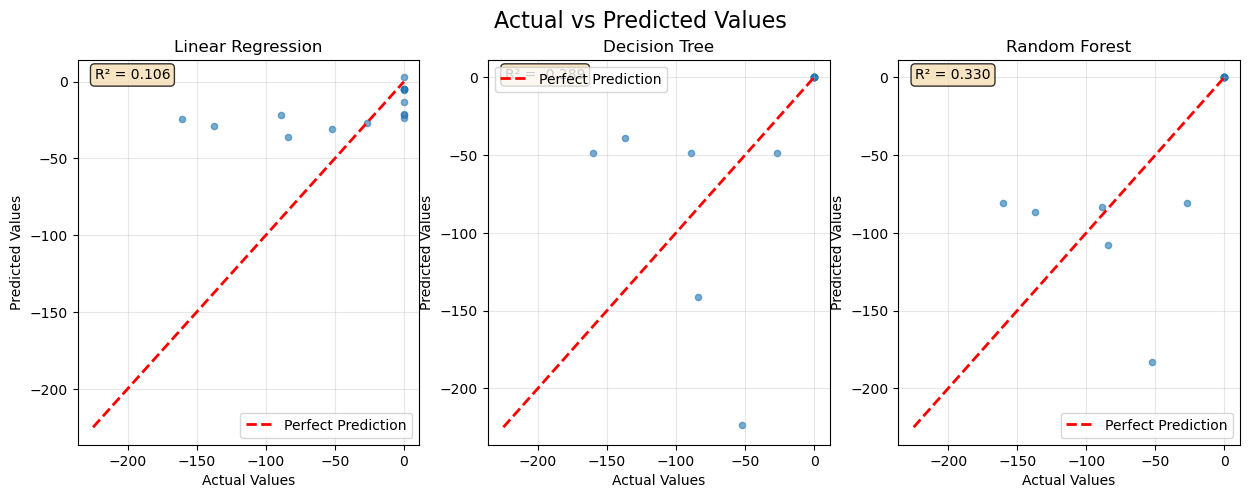

In [ ]:
# Обучаем финальные модели на всей обучающей выборке
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=21, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=21, n_estimators=100, max_depth=10)
}

# Обучаем модели и делаем предсказания
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred
    
    # Вычисляем RMSE на тестовой выборке
    test_rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{name} - Test RMSE: {test_rmse:.4f}")

# Визуализация: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Actual vs Predicted Values', fontsize=16)

for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Scatter plot: actual vs predicted
    ax.scatter(y_test, pred, alpha=0.6, s=20)
    
    # Идеальная линия (y = x)
    min_val = -225
    max_val = 0
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Добавляем R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, pred)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.show()


Linear Regression - Test RMSE: 45.3492
Decision Tree - Test RMSE: 0.0000
Random Forest - Test RMSE: 13.9266


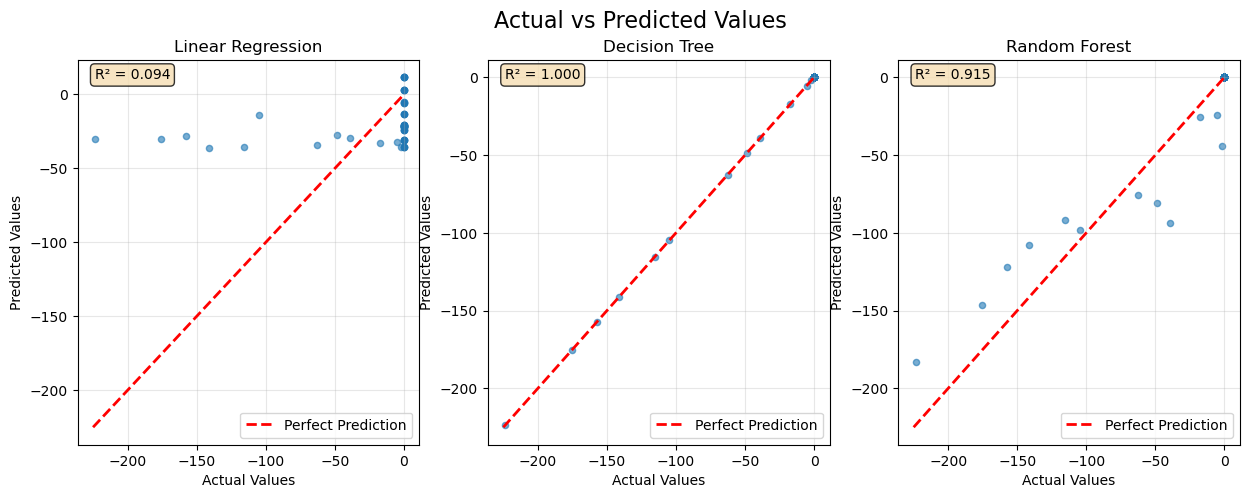

In [ ]:
# Обучаем финальные модели на всей обучающей выборке
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=21, max_depth=10),
    'Random Forest': RandomForestRegressor(random_state=21, n_estimators=100, max_depth=10)
}

# Обучаем модели и делаем предсказания
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    predictions[name] = pred
    
    # Вычисляем RMSE на тестовой выборке
    test_rmse = np.sqrt(mean_squared_error(y_train, pred))
    print(f"{name} - Test RMSE: {test_rmse:.4f}")

# Визуализация: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Actual vs Predicted Values', fontsize=16)

for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Scatter plot: actual vs predicted
    ax.scatter(y_train, pred, alpha=0.6, s=20)
    
    min_val = -225
    max_val = 0
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Добавляем R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(y_train, pred)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# plt.tight_layout()
plt.show()


#### 📈 R² - R-squared, коэффициент детерминации
#### 🎯 Что показывает:

- Какую долю разброса целевой переменной объясняет модель
- Диапазон: от 0 до 1 (иногда может быть отрицательным)

#### 📊 Интерпретация R² = 0.23:

- Модель объясняет 23% вариаций в данных
- 77% остается необъясненным (шум, пропущенные признаки, etc.)
- Это довольно слабый результат для ML

#### 🔢 Шкала R²:

- R² = 1.0 → Идеальная модель (100% объяснено)
- R² = 0.7-0.9 → Хорошая модель
- R² = 0.3-0.7 → Средняя модель
- R² = 0.0-0.3 → Слабая модель ← ТЫ ЗДЕСЬ
- R² < 0 → Модель хуже простого среднего

In [51]:
results_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'CV_RMSE': [lr_rmse, dt_rmse, rf_rmse],
    'Test_RMSE': [
        np.sqrt(mean_squared_error(y_test, predictions['Linear Regression'])),
        np.sqrt(mean_squared_error(y_test, predictions['Decision Tree'])),
        np.sqrt(mean_squared_error(y_test, predictions['Random Forest']))
    ]
})

results_summary

,Model,CV_RMSE,Test_RMSE
0,Linear Regression,41.129085,49.628610
1,Decision Tree,31.965758,59.597098
2,Random Forest,27.729027,42.965878


### Decision Tree плох на тесте из-за переобучения
#### (и поэтому на кроссвалидации были нули в ошибках)

## 🎯 Ответ на вопрос: Как должен выглядеть идеальный график?
### (How would plot look like in the ideal case?)

### В идеальном случае график 'Actual vs Predicted' должен представлять собой ДИАГОНАЛЬ

1. 📍 Прямую линию под углом 45° (y = x)
   - Все точки лежат точно на красной пунктирной линии
   - Это означает: предсказание = реальное значение

2. 📊 Характеристики идеального графика:
   - R² = 1.0 (100% объясненной дисперсии)
   - RMSE = 0 (нулевая ошибка)
   - Нет разброса точек вокруг линии

3. 🔍 В реальности мы видим:
   - Облако точек вокруг идеальной линии
   - Чем ближе точки к линии, тем лучше модель
   - Систематические отклонения указывают на bias модели

4. 🚩 Плохие паттерны:
   - Изогнутые формы (нелинейные зависимости)
   - Воронкообразные паттерны (гетероскедастичность)
   - Горизонтальные полосы (модель игнорирует вариации)